# Import required libraries and define the required functions

In [1]:
import cv2 as cv
import numpy as np
import urllib.request
from matplotlib import pyplot as plt
from numba import jit
from ultralytics import YOLO

# import Models
model = YOLO('./models/yolov8n-seg.pt')
# model = YOLO('./models/yolov8x-seg.pt')
# model = YOLO('./models/yolov8s-seg.pt')
# model = YOLO('./models/yolov8m-seg.pt')
# model = YOLO('./models/yolov9c-seg.pt')
# model = YOLO('./models/yolov9e-seg.pt')
# model = YOLO('./models/yolo11n-seg.pt')
# model = YOLO('./models/yolo11x-seg.pt')
# model = YOLO('./models/yolo11s-seg.pt')
# model = YOLO('./models/yolo11m-seg.pt')


# Setting up focal length, Image number and baseline

In [2]:
img = 3
focal_length = 694
baseline = 3 // 100

# Required Functions

In [8]:
@jit(nopython=True)
def downScale(image, n):
    modifiedImage = np.floor_divide(image, 2**n)
    return modifiedImage

@jit(nopython=True)
def upScale(image, n):
    modifiedImage = np.multiply(image, 2**n) 
    return modifiedImage.astype(np.uint8)

def disparity_to_depth(disparity_map):
    disparity_map[disparity_map <= 0] = 0.1
    depth_map = (focal_length * baseline) / disparity_map

    return depth_map

@jit(nopython=True)
def brightnessUP(image, b_level):
    return image + b_level

def contrastup(img, gamma):
    modified_img = np.array(np.clip(pow(img / 255.0, gamma) * 255.0, 0, 255), dtype=np.uint8)
    modified_img = np.clip(modified_img + 20, 0, 255)
    return modified_img

def scalelinear(img):
    max_intensity = np.max(img)
    min_intensity = np.min(img)
    modified = np.array(np.clip((img -min_intensity) * (255 / (max_intensity-min_intensity)), 0,  255), dtype=np.uint8)
    return modified

def segment_color(img, probability):
    temp = np.copy(img)
    results = model.predict(img, conf=probability)
    if len(results) > 0:
        for result in results:
            for mask, box in zip(result.masks.xy, result.boxes):
                points = np.int32([mask])
                cv.fillPoly(temp, points, 1)
    return temp - img

def viewImages(original, modified, text): 
    plt.figure(figsize=(9,9)) 

    plt.subplot(1,2,1) 
    plt.imshow(original) 
    plt.title('Orignal') 
    plt.axis('off') 

    plt.subplot(1,2,2) 
    plt.imshow(modified) 
    plt.title(text) 
    plt.axis('off') 
    plt.savefig('./maps/'+text+'.png', dpi=300)
    plt.tight_layout()


# For testing purposes, import stored images.

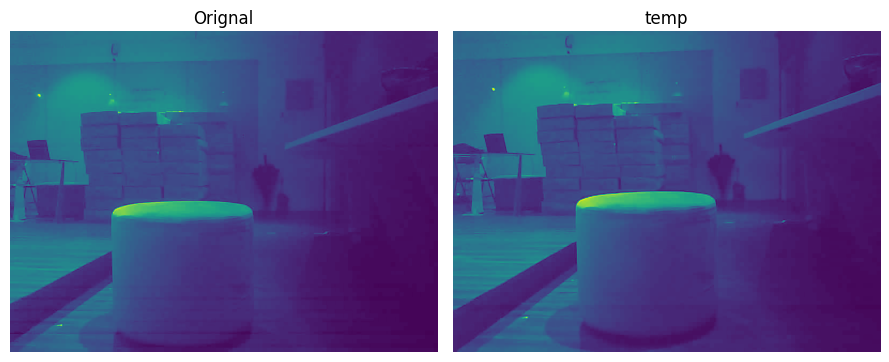

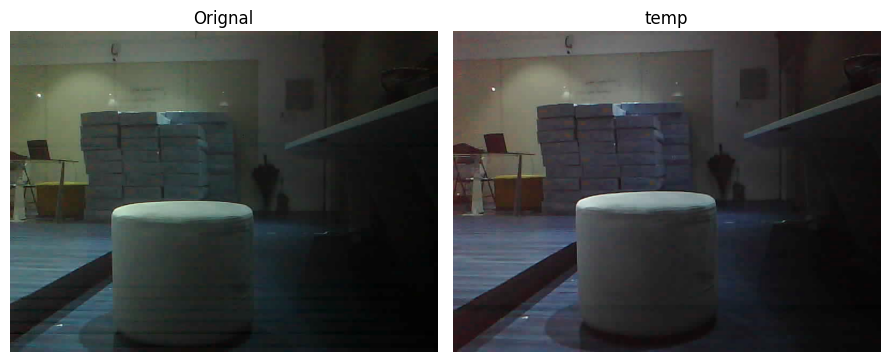

In [5]:
l_img_name = './updated/L_'+str(img)+'0.png'
r_img_name = './updated/R_'+str(img)+'0.png'

left_img = cv.imread(l_img_name, cv.IMREAD_GRAYSCALE)
right_img = cv.imread(r_img_name, cv.IMREAD_GRAYSCALE)
viewImages(left_img, right_img, "temp")

left_color_img = cv.imread(l_img_name, cv.IMREAD_COLOR)
right_color_img = cv.imread(r_img_name, cv.IMREAD_COLOR)
viewImages(left_color_img, right_color_img, "temp")

# Getting images using ESP Cameras

In [ ]:
left_url = 'http://192.168.205.216/cam-hi.jpg'
right_url = 'http://192.168.205.172/cam-hi.jpg'

left_img_resp=urllib.request.urlopen(left_url)
right_img_resp=urllib.request.urlopen(right_url)

left_imgnp=np.array(bytearray(left_img_resp.read()),dtype=np.uint8)
right_imgnp=np.array(bytearray(right_img_resp.read()),dtype=np.uint8)

left_color_img = cv.imdecode(left_imgnp,-1)
right_color_img = cv.imdecode(right_imgnp,-1)

left_img = cv.cvtColor(left_color_img, cv.COLOR_BGR2GRAY)
right_img = cv.cvtColor(right_color_img, cv.COLOR_BGR2GRAY)

# Getting images using USB cameras

In [ ]:
cap_left = cv.VideoCapture(0)
cap_right=cv.VideoCapture(1)

rect_left, left_img = cap_left.read()
rect_right, right_img = cap_right.read()

# Stereo Processing Algorithms

In [9]:
# Use SAD Algorithm for calculate disparities ---------------------------------------------------------------
@jit(nopython=True)
def compute_disparity_SAD(left_img, right_img, block_size, disparities):
    h, w = left_img.shape
    disparity = np.zeros((h, w), np.uint8)
    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1,
                                       x - half_block:x + half_block + 1]

            min_sad = block_size ** 2 * 255
            best_disparity = 0

            for d in range(disparities):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1,
                                                 x_right - half_block:x_right + half_block + 1]

                    sad = np.sum(np.abs(left_block.astype(np.int32) - right_block.astype(np.int32)))

                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d

            disparity[y, x] = best_disparity

    return disparity

# Use SSD Algorithm for calculate disparities ---------------------------------------------------------------
@jit(nopython=True)
def compute_disparity_SSD(left_img, right_img, block_size, max_disparity):
    h, w = left_img.shape

    disparity = np.zeros((h, w), np.uint8)

    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1,
                                       x - half_block:x + half_block + 1]

            min_ssd = block_size ** 2 * 255
            best_disparity = 0

            for d in range(max_disparity):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1,
                                                 x_right - half_block:x_right + half_block + 1]

                    ssd = np.sum((left_block.astype(np.int32) - right_block.astype(np.int32)) ** 2)

                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_disparity = d
            disparity[y, x] = best_disparity

    return disparity

# Use NCC Algorithm for calculate disparities ---------------------------------------------------------------
@jit(nopython=True)
def compute_disparity_NCC(left_img, right_img, block_size, max_disparity):

    h, w = left_img.shape

    disparity_map = np.zeros((h, w), np.float32)

    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            left_mean = np.mean(left_block)

            best_ncc = -1
            best_disparity = 0

            for d in range(max_disparity):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1, x_right - half_block:x_right + half_block + 1]

                    right_mean = np.mean(right_block)

                    numerator = np.sum((left_block - left_mean) * (right_block - right_mean))
                    left_norm = np.sum((left_block - left_mean) ** 2)
                    right_norm = np.sum((right_block - right_mean) ** 2)
                    denominator = np.sqrt(left_norm * right_norm)

                    if denominator > 0:
                        ncc_score = numerator / denominator

                        if ncc_score > best_ncc:
                            best_ncc = ncc_score
                            best_disparity = d

            disparity_map[y, x] = best_disparity

    return disparity_map

# Getting disparity maps using SAD, SSD, NCC Algorithms

In [ ]:
# SAD Algorithm - Changing Disparities block size - 3 disparities - 10 to 208

fig, axs = plt.subplots(10, 5, figsize=(75,75))

for i in range(50):
    disparity = compute_disparity_SAD(left_img, right_img, 3, 2 * i + 10)
    
    axs[i//5, i % 5].imshow(disparity)
    axs[i//5, i % 5].axis('off')
    axs[i//5, i % 5].set_title(f"D : {i}")

plt.tight_layout()
plt.savefig('./updated_maps/SAD_dp_block:3_baseline:3.png', dpi=300)
plt.show()

In [ ]:
# SAD Algorithm - Changing Block sizes block size - 3 to 27 disparities - 32

fig, axs = plt.subplots(6, 3, figsize=(75,75))

for i in range(18):
    disparity = compute_disparity_SAD(left_img, right_img, i * 2 + 3, 32)
    
    axs[i//3, i % 3].imshow(disparity)
    axs[i//3, i % 3].axis('off')
    axs[i//3, i % 3].set_title(f"D : {i}")

plt.tight_layout()
plt.savefig('./updated_maps/SAD_dp_block:v_baseline:3.png', dpi=300)
plt.show()

In [ ]:
# SSD Algorithm - Changing Disparities block size - 3 disparities - 10 to 208

fig, axs = plt.subplots(10, 5, figsize=(75,75))

for i in range(50):
    disparity = compute_disparity_SSD(left_img, right_img, 3, 2 * i + 10)
    
    axs[i//5, i % 5].imshow(disparity)
    axs[i//5, i % 5].axis('off')
    axs[i//5, i % 5].set_title(f"D : {i}")

plt.tight_layout()
plt.savefig('./updated_maps/SSD_dp_block:3_baseline:3.png', dpi=300)
plt.show()

In [ ]:
# SSD Algorithm - Changing Block sizes block size - 3 to 27 disparities - 32

fig, axs = plt.subplots(6, 3, figsize=(75,75))

for i in range(18):
    disparity = compute_disparity_SSD(left_img, right_img, i * 2 + 3, 32)
    
    axs[i//3, i % 3].imshow(disparity)
    axs[i//3, i % 3].axis('off')
    axs[i//3, i % 3].set_title(f"D : {i}")

plt.tight_layout()
plt.savefig('./updated_maps/SSD_dp_block:v_baseline:3.png', dpi=300)
plt.show()

In [ ]:
# NCC Algorithm - Changing Disparities block size - 3 disparities - 10 to 208

fig, axs = plt.subplots(10, 10, figsize=(75,75))

for i in range(100):
    disparity = compute_disparity_NCC(left_img, right_img, 3, 2 * i + 10)
    
    axs[i//10, i % 10].imshow(disparity)
    axs[i//10, i % 10].axis('off')
    axs[i//10, i % 10].set_title(f"D : {i}")

plt.tight_layout()
plt.savefig('./updated_maps/NCC_dp_block:3_baseline:3.png', dpi=300)
plt.show()

In [ ]:
# NCC Algorithm - Changing Block sizes block size - 3 to 27 disparities - 32

fig, axs = plt.subplots(6, 3, figsize=(75,75))

for i in range(18):
    disparity = compute_disparity_NCC(left_img, right_img, i * 2 + 3, 32)
    
    axs[i//3, i % 3].imshow(disparity)
    axs[i//3, i % 3].axis('off')
    axs[i//3, i % 3].set_title(f"D : {i}")

plt.tight_layout()
plt.savefig('./updated_maps/NCC_dp_block:v_baseline:3.png', dpi=300)
plt.show()

# Thresholding and compute the disparity map

In [ ]:
ret, l_t_img_1 = cv.threshold(left_img, 127, 255, cv.THRESH_BINARY)
viewImages(left_img, l_t_img_1, "Normal Thresholding")

l_t_img_2 = cv.adaptiveThreshold(left_img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
viewImages(left_img, l_t_img_2, "Adaptive Mean Thresholding")

l_t_img_3 = cv.adaptiveThreshold(right_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
viewImages(left_img, l_t_img_3, "Adaptive Gaussian Thresholding")

l_b_img = cv.GaussianBlur(left_img,(5,5),0)
ret3,l_t_img_4 = cv.threshold(l_b_img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
viewImages(left_img, l_t_img_4, "Otsu's Thresholding")


# Increase Contrast, Brightness, and change bits and compute disparity map

In [ ]:
left_img = cv.imread("./images/OV2640/imageOV2640R2.png", cv.IMREAD_GRAYSCALE)
right_img = cv.imread("./images/OV2640/imageOV2640L2.png", cv.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(3, 3, figsize=(100,100))

for i in range(0,9):
    left_img = contrastup(left_img, (i+1)/10)
    right_img = contrastup(right_img, (i+1)/10)

    l_temp = downScale(left_img, 4)
    r_temp = downScale(right_img, 4)

    l_temp = scalelinear(l_temp)
    r_temp = scalelinear(r_temp)

    disparity = compute_disparity_SAD(r_temp, l_temp, 3, 400)
    depth = disparity_to_depth(disparity)

# viewImages(left_img, depth, "temp")
    axs[i//3, i % 3].imshow(disparity)
    axs[i//3, i % 3].axis('off')
    axs[i//3, i % 3].set_title(f"Gamma : {i}")

plt.tight_layout()
plt.savefig('./maps/Gamma_change_SAD.png', dpi=300)
plt.show()

In [ ]:
left_img = cv.imread("./images/OV2640/imageOV2640R2.png", cv.IMREAD_GRAYSCALE)
right_img = cv.imread("./images/OV2640/imageOV2640L2.png", cv.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(3, 3, figsize=(75,75))

for i in range(9):
    left_img = contrastup(left_img, (i+1)/10)
    right_img = contrastup(right_img, (i+1)/10)

    l_temp = downScale(left_img, 5)
    r_temp = downScale(right_img, 5)

    l_temp = scalelinear(l_temp)
    r_temp = scalelinear(r_temp)

    disparity = compute_disparity_SSD(r_temp, l_temp, 3, 400)
    depth = disparity_to_depth(disparity)

    axs[i//3, i % 3].imshow(disparity)
    axs[i//3, i % 3].axis('off')
    axs[i//3, i % 3].set_title(f"Gamma : {i}")

plt.tight_layout()
plt.savefig('./maps/Gamma_change_SSD.png', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(75,75))

for i in range(9):
    left_img = contrastup(left_img, (i+1)/10)
    right_img = contrastup(right_img, (i+1)/10)

    l_b_img = cv.GaussianBlur(left_img,(5,5),0)
    r_b_img = cv.GaussianBlur(right_img,(5,5),0)
    ret3,l_t_img_4 = cv.threshold(l_b_img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret3,r_t_img_4 = cv.threshold(r_b_img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    l_temp = downScale(left_img, 5)
    r_temp = downScale(right_img, 5)

    l_temp = upScale(l_temp, 5)
    r_temp = upScale(r_temp, 5)

    disparity = compute_disparity_SSD(r_temp, l_temp, 3, 400)
    depth = disparity_to_depth(disparity)

    axs[i//3, i % 3].imshow(disparity)
    axs[i//3, i % 3].axis('off')
    axs[i//3, i % 3].set_title(f"Gamma : {i}")

plt.tight_layout()
plt.savefig('./maps/Gamma_O_change_SSD.png', dpi=300)
plt.show()

# Segmentation

In [ ]:
seg_l = np.array(segment_color(left_color_img, 0.1), dtype=np.uint8)
seg_r = np.array(segment_color(right_color_img, 0.1), dtype=np.uint8)

seg_l = cv.cvtColor(seg_l, cv.COLOR_BGR2GRAY)
seg_r = cv.cvtColor(seg_r, cv.COLOR_BGR2GRAY)
